## Part 1. Importing the architectural plans as graphs from GH .txt output

In [2]:
import os
import pandas as pd
import numpy as np
import re
import ast
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

% matplotlib inline

plt.rcParams['figure.figsize'] = 12, 8

First of all, we need to locate all the text files we need to import.
We assume the .txt file is located as follows:

Processed file -> Mosques/Monasteries -> plan name -> plan_name.txt

In [153]:
def list_file_graphs(rootdir, text_to_be_avoided=['link', 'comment']):
    
    out_files = []
    
    # First we retrieve all the subfolder of the rootdirectory
    subfolder_list = [os.path.join(rootdir, o) for o in os.listdir(rootdir) 
                      if os.path.isdir(os.path.join(rootdir,o))]
    
    # Then for each of the subfolder we select only the txt file
    for subfolder in subfolder_list:
        file_list = [os.path.join(subfolder, o) for o in os.listdir(subfolder) 
                     if not os.path.isdir(os.path.join(subfolder,o))]
        txt_file = [el for el in file_list if el.endswith('.txt')]
        for avoid_word in text_to_be_avoided:
            txt_file = [el for el in txt_file if avoid_word not in el]
        
        if len(txt_file) > 1:
            print 'More than one txt file found in %s:. Only first one selected.' % (subfolder)
            print txt_file
        
        if not txt_file:
            print 'No .txt files found in %s.' % (subfolder)
            continue
        
        out_files.append(txt_file[0])
        
    return out_files

filename_dict = {'Mosques': [], 'Monasteries': []}
filename_dict['Mosques'] = list_file_graphs('processed_files/Mosques/')
filename_dict['Monasteries'] = list_file_graphs('processed_files/Monasteries/')    

No .txt files found in processed_files/Mosques/FLS1580.
No .txt files found in processed_files/Mosques/FLS1323.
No .txt files found in processed_files/Mosques/FLS1455.
No .txt files found in processed_files/Monasteries/7.
No .txt files found in processed_files/Monasteries/8.


In [154]:
for j, el in enumerate(filename_dict['Mosques']):
    print j, el
    
print '\n'
    
for j, el in enumerate(filename_dict['Monasteries']):
    print j, el

0 processed_files/Mosques/FLS1573/FLS1573.txt
1 processed_files/Mosques/FLS1544/FLS1544.txt
2 processed_files/Mosques/FLS1543/FLS1543.txt
3 processed_files/Mosques/FLS1603/FLS1603.txt
4 processed_files/Mosques/FLS1621/FLS1621.txt
5 processed_files/Mosques/FLS1610/FLS1610.txt
6 processed_files/Mosques/FLS1449/FLAS1449.txt
7 processed_files/Mosques/FLS1447/FLAS1447.txt
8 processed_files/Mosques/FLS1561/FLS1561.txt
9 processed_files/Mosques/FLS1307/FLS1307.txt
10 processed_files/Mosques/FLS1317/FLS1317.txt
11 processed_files/Mosques/FLS1576/FLS1576.txt
12 processed_files/Mosques/FLS1609/FLS1609.txt
13 processed_files/Mosques/FLS1445/FLS1445.txt
14 processed_files/Mosques/FLS1285/FLS1285.txt
15 processed_files/Mosques/FLS1443/FLS1443.txt
16 processed_files/Mosques/FLS1279/FLS1279.txt
17 processed_files/Mosques/FLS1614/FLS1614.txt
18 processed_files/Mosques/FLS1563/FLS1563.txt
19 processed_files/Mosques/FLS1303/FLS1303.txt


0 processed_files/Monasteries/18/18.txt
1 processed_files/Monaster

Then we want to read-in the files.
We are going to create a pandas dataframe for each of the txt file.

In [155]:
def create_pd_dataframe(file_list, header=True, colnames=['index','area','connectivity','isovistArea']):
    
    output_list_dfs = []
    
    for filename in file_list:
        with open(filename, 'r') as f:
            
            lines = [el.rstrip() for el in f.readlines()]  #Remove trailing spaces
            lines = [el for el in lines if 'https' not in el and el!='']   #Remove lines which are not useful
            
            df_data = []
            
            for j, line in enumerate(lines):
                
                if header and j==0:
                    if not colnames:
                        colnames = line.split(',')
                    continue
                
                list_connection_str = re.findall('\[.*?\]',line)
                if not list_connection_str:
                    print lines
                    print list_connection_str
                    raise ValueError('The room considered seems to have no connection value entered.\n'
                          'Line %s of file %s' % (j, filename))

                list_connection = ast.literal_eval(list_connection_str[0])
                line_temp_no_connection = line.replace(list_connection_str[0], '')

                line_temp_separation = [el for el in line_temp_no_connection.split(',') if el]
                index_room, area, area_isovist = line_temp_separation
                
                # Some of the index room are not only number but '0. 1' type of strings,
                # in which 0. is just the index of the row and 1 is the room index
                # Solving that problem:
                try:
                    index_room = int(index_room)
                except ValueError:
                    index_room = int(index_room.split('.')[1])
                    
                area = int(area)
                area_isovist = int(area_isovist)
                
                df_data.append([index_room, area, list_connection, area_isovist])
            
            df_temp = pd.DataFrame.from_records(data=df_data, columns=colnames)
        
        # Number of connections for each room is added
        df_temp['n_connections'] = df_temp['connectivity'].apply(lambda x: len(x)) 
        output_list_dfs.append(df_temp)
    
    return output_list_dfs


dataframe_dict = {'Mosques': [], 'Monasteries': []}
dataframe_dict['Mosques'] = create_pd_dataframe(filename_dict['Mosques'])
dataframe_dict['Monasteries'] = create_pd_dataframe(filename_dict['Monasteries'])

We would like to have the following:
- Only have the adjecency matrix for each of the plan
- Have a dataframe with each line being a series of features for each datasets

In [156]:
## Adjecency matrix (working with numpy matrix rather than sparse just to make sure that things are consistent)

def return_adjecency_matrix(df_list, prune_closed_room=False):
    '''
    Pruned closed room removes the lines which refer to room which only communicate with the external
    part of the plan.
    '''
    
    adj_mat_list = []
    
    for df in df_list:
        try:
            n_room = np.max([int(el) for el in df['index'].values]) + 1
        except:
            print df
        adj_mat_temp = np.diag(np.ones(n_room))
        
        for conn_list in df['connectivity'].values:
            for tuple_conn in conn_list:
                adj_mat_temp[tuple_conn[0], tuple_conn[1]] = 1
                adj_mat_temp[tuple_conn[1], tuple_conn[0]] = 1
        
        if prune_closed_room:
            indeces_single_room = np.where(np.sum(adj_mat_temp, axis=1) == 1)[0]
            adj_mat_temp = np.delete(adj_mat_temp, indeces_single_room, axis=0)
            adj_mat_temp = np.delete(adj_mat_temp, indeces_single_room, axis=1)
        
        adj_mat_list.append(adj_mat_temp)
    
    return adj_mat_list
        
adjecency_mat_dict = {'Mosques': {'Full': [], 'No_1degree': []}, 
                     'Monasteries': {'Full': [], 'No_1degree': []},}
adjecency_mat_dict['Mosques']['Full'] = return_adjecency_matrix(dataframe_dict['Mosques'], False)
adjecency_mat_dict['Mosques']['No_1degree'] = return_adjecency_matrix(dataframe_dict['Mosques'], True)
adjecency_mat_dict['Monasteries']['Full'] = return_adjecency_matrix(dataframe_dict['Monasteries'], False)
adjecency_mat_dict['Monasteries']['No_1degree'] = return_adjecency_matrix(dataframe_dict['Monasteries'], True)

In [181]:
## Save the adjecency matrices in separate files to be read by R

folder = 'data/full_adj/'
type_adj = 'Full'

for bld_type in ['Mosques', 'Monasteries']:
    temp_list = adjecency_mat_dict[bld_type][type_adj]
    for j, adj_mat in enumerate(temp_list):
        print adj_mat.shape
        np.savetxt(fname=folder+bld_type+'_'+str(j)+'.txt', X=adj_mat, delimiter='|')
    print '\n'

(36, 36)
(95, 95)
(130, 130)
(75, 75)
(4, 4)
(14, 14)
(10, 10)
(43, 43)
(89, 89)
(14, 14)
(74, 74)
(9, 9)
(22, 22)
(4, 4)
(19, 19)
(11, 11)
(14, 14)
(46, 46)
(99, 99)
(34, 34)


(37, 37)
(25, 25)
(69, 69)
(39, 39)
(38, 38)
(33, 33)
(50, 50)
(59, 59)
(30, 30)
(35, 35)
(35, 35)
(25, 25)
(74, 74)
(30, 30)
(15, 15)
(42, 42)
(31, 31)
(23, 23)
(37, 37)




In [158]:
full_dict = {'filename': filename_dict,
            'dataframe': dataframe_dict,
            'adjecency_mat': adjecency_mat_dict}

pickle.dump(full_dict, open('processed_dict/graph_dict_flnms_dfs_adjmats.pkl', 'wb'))

## Part 2. Exploration on how to determine the features

Outputs the three features we can determine at a room level, explore how features can be grouped and then groups them and saves them at a building level.

In [3]:
full_dict = pickle.load(open('processed_dict/graph_dict_flnms_dfs_adjmats.pkl', 'rb'))
dataframe_dict = full_dict['dataframe']

In [4]:
# I am creating a big dataframe, in which every row is a room in a building

colnames = ['index_building', 'index_room', 'n_connections', 'area', 'isovistArea', 'building_type']
full_df = None

for key, df_list in dataframe_dict.iteritems():
    for j, df in enumerate(df_list):
        df_temp = df.copy()
        df_temp['index_room'] = df_temp['index']
        df_temp['index_building'] = j
        df_temp['building_type'] = key
        
        if full_df is None:
            full_df = df_temp[colnames]
        else:
            full_df = pd.concat([full_df, df_temp[colnames]])

print 'Final Dataset shape is ', full_df.shape
full_df.to_csv('data/room_level_data.csv')

Final Dataset shape is  (1569, 6)


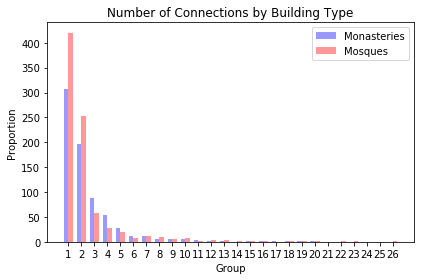

In [5]:
from collections import Counter, defaultdict

fig, ax = plt.subplots()

index = np.arange(len(full_df['n_connections'].unique()))[1:]
bar_width = 0.35

bar_plot_dict = {'Monasteries': [], 'Mosques': []}

for bld_name in bar_plot_dict.keys():
    connection_bld = full_df[full_df['building_type'] == bld_name]['n_connections'].values
    connection_bld_counter = Counter(connection_bld)
    total_sum = float(np.sum(connection_bld_counter.values()))
    for value_idx in index:
        if value_idx in connection_bld_counter.keys():
            bar_plot_dict[bld_name].append(connection_bld_counter[value_idx])
        else:
            bar_plot_dict[bld_name].append(0)

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, 
                bar_plot_dict['Monasteries'], 
                bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='Monasteries')

rects2 = ax.bar(index + bar_width, 
                bar_plot_dict['Mosques'], 
                bar_width,
                alpha=opacity, color='r',
                error_kw=error_config,
                label='Mosques')

ax.set_xlabel('Group')
ax.set_ylabel('Proportion')
ax.set_title('Number of Connections by Building Type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()

fig.tight_layout()
plt.show()

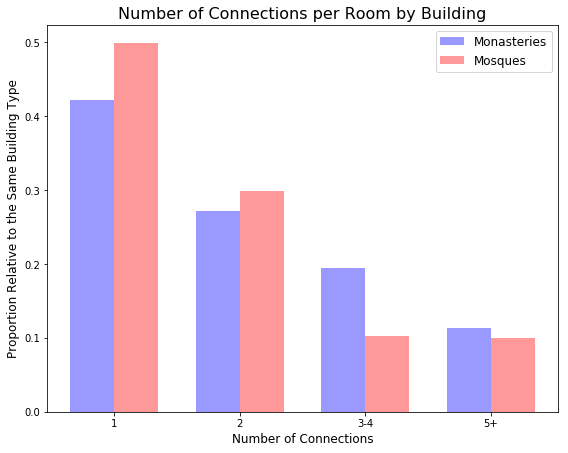

In [14]:
from collections import Counter, defaultdict
plt.rcParams['figure.figsize'] = 8, 6.4


fig, ax = plt.subplots()

index = np.arange(len(full_df['n_connections'].unique()))
bar_width = 0.35

bar_plot_dict = {'Monasteries': [], 'Mosques': []}

for bld_name in bar_plot_dict.keys():
    connection_bld = full_df[full_df['building_type'] == bld_name]['n_connections'].values
    connection_bld_counter = Counter(connection_bld)
    # Hijiacking the counter
    dict_counter_custom = defaultdict(lambda: 0)
    for key, value in connection_bld_counter.iteritems():
        if key <= 1:
            dict_counter_custom[key] += value
        elif key <= 2:
            dict_counter_custom[2] += value
        elif key <= 4:
            dict_counter_custom[3] += value
        else:
            dict_counter_custom[4] += value
    connection_bld_counter = dict_counter_custom
    index = np.array(sorted(connection_bld_counter.keys()))
    
    total_sum = float(np.sum(connection_bld_counter.values()))
    for value_idx in index:
        if value_idx in connection_bld_counter.keys():
            bar_plot_dict[bld_name].append(connection_bld_counter[value_idx]/total_sum)
        else:
            bar_plot_dict[bld_name].append(0)


opacity = 0.4
error_config = {'ecolor': '0.3'}


rects1 = ax.bar(index, 
                bar_plot_dict['Monasteries'], 
                bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='Monasteries')

rects2 = ax.bar(index + bar_width, 
                bar_plot_dict['Mosques'], 
                bar_width,
                alpha=opacity, color='r',
                error_kw=error_config,
                label='Mosques')

ax.set_xlabel('Number of Connections', fontsize=12)
ax.set_ylabel('Proportion Relative to the Same Building Type', fontsize=12)
ax.set_title('Number of Connections per Room by Building', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['1', '2', '3-4', '5+'])
ax.legend(fontsize=12)

fig.tight_layout()
plt.savefig('images/n_connections_room.png', dpi=600)
plt.show()

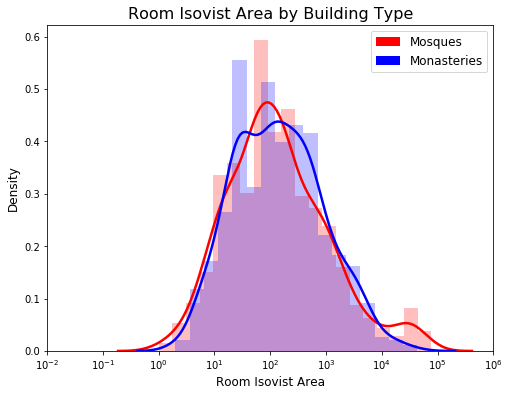

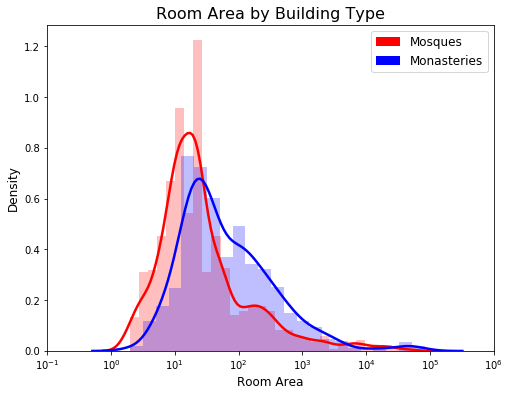

In [7]:
col_plot_dict = { 'area': {'log': True, 'xlim':False, 'kde':True, 'name': 'Room Area'},
                 'isovistArea': {'log': True,'xlim':False, 'kde':True, 'name': 'Room Isovist Area'}}
color_vec = ['red', 'blue']
bld_type_vec = full_df['building_type'].unique()

for col_plot in col_plot_dict.keys():
    for j, building_type in enumerate(bld_type_vec):
        temp_plot_df = full_df[full_df['building_type'] == building_type]
        if col_plot_dict[col_plot]['log']:
            sns.distplot(np.log10(temp_plot_df[col_plot].values + 1), label=building_type, hist_kws= {'alpha':0.25},
                 kde_kws={'lw':2.5}, color=color_vec[j], kde=col_plot_dict[col_plot]['kde'])
        else:
            sns.distplot(temp_plot_df[col_plot], label=building_type, hist_kws= {'alpha':0.25},
                 kde_kws={'lw':2.5}, color=color_vec[j], kde=col_plot_dict[col_plot]['kde'])
    plt.title('%s by Building Type' % (col_plot_dict[col_plot]['name']), fontsize=16)
    plt.xlabel(col_plot_dict[col_plot]['name'], fontsize=12)
    plt.ylabel('Density', fontsize=12)
    if col_plot_dict[col_plot]['log']:
        locs, labels = plt.xticks()
        plt.xticks(locs, ['$10^{%s}$' % (int(loc)) for loc in locs])
    leg = plt.legend(loc='best',  fontsize=12)
    for lh in leg.legendHandles: 
        lh.set_facecolor(lh.get_facecolor())
        #lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    if col_plot_dict[col_plot]['xlim']:
        plt.xlim(col_plot_dict[col_plot]['xlim'])
    plt.show()

In [8]:
from itertools import combinations

bld_type_vec = full_df['building_type'].unique()

for bld_type in bld_type_vec:
    temp_df = full_df[full_df['building_type'] == bld_type]
    
    for col1, col2 in combinations(['n_connections', 'area', 'isovistArea'], 2):
        corr_temp = np.corrcoef(temp_df[col1].values, temp_df[col2].values)[0,1]
        print '%s, Correlation between %s and %s : %s' % (bld_type, col1, col2, round(corr_temp, 2))
    print '\n'

Mosques, Correlation between n_connections and area : 0.49
Mosques, Correlation between n_connections and isovistArea : 0.08
Mosques, Correlation between area and isovistArea : 0.28


Monasteries, Correlation between n_connections and area : 0.32
Monasteries, Correlation between n_connections and isovistArea : 0.08
Monasteries, Correlation between area and isovistArea : 0.21




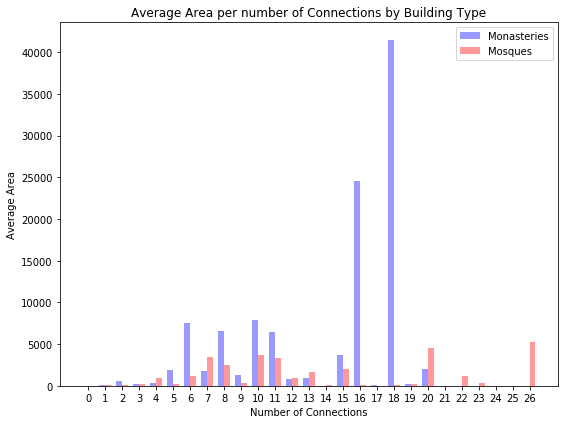

In [9]:
## Average Area by number of connections


from collections import Counter

fig, ax = plt.subplots()

index = np.arange(len(full_df['n_connections'].unique()))
bar_width = 0.35

bar_plot_dict = {'Monasteries': [], 'Mosques': []}

for bld_name in bar_plot_dict.keys():
    temp_df = full_df[full_df['building_type'] == bld_name]
    connection_bld = temp_df['n_connections'].values
    connection_bld_counter = Counter(connection_bld)
    total_sum = float(np.sum(connection_bld_counter.values()))
    for value_idx in index:
        if value_idx in connection_bld_counter.keys():
            temp_value = np.average(temp_df[temp_df['n_connections'] == value_idx]['area'])
            bar_plot_dict[bld_name].append(temp_value)
        else:
            bar_plot_dict[bld_name].append(0)


opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, 
                bar_plot_dict['Monasteries'], 
                bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='Monasteries')

rects2 = ax.bar(index + bar_width, 
                bar_plot_dict['Mosques'], 
                bar_width,
                alpha=opacity, color='r',
                error_kw=error_config,
                label='Mosques')

ax.set_xlabel('Number of Connections')
ax.set_ylabel('Average Area')
ax.set_title('Average Area per number of Connections by Building Type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()

fig.tight_layout()
plt.show()

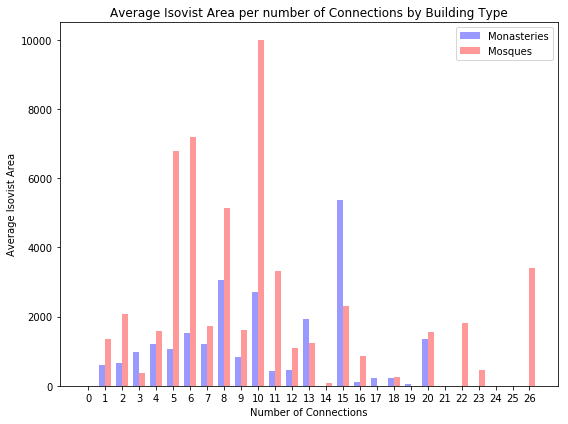

In [11]:
## Average Area by number of connections


from collections import Counter

fig, ax = plt.subplots()

index = np.arange(len(full_df['n_connections'].unique()))
bar_width = 0.35

bar_plot_dict = {'Monasteries': [], 'Mosques': []}

for bld_name in bar_plot_dict.keys():
    temp_df = full_df[full_df['building_type'] == bld_name]
    connection_bld = temp_df['n_connections'].values
    connection_bld_counter = Counter(connection_bld)
    total_sum = float(np.sum(connection_bld_counter.values()))
    for value_idx in index:
        if value_idx in connection_bld_counter.keys():
            temp_value = np.average(temp_df[temp_df['n_connections'] == value_idx]['isovistArea'])
            bar_plot_dict[bld_name].append(temp_value)
        else:
            bar_plot_dict[bld_name].append(0)


opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, 
                bar_plot_dict['Monasteries'], 
                bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='Monasteries')

rects2 = ax.bar(index + bar_width, 
                bar_plot_dict['Mosques'], 
                bar_width,
                alpha=opacity, color='r',
                error_kw=error_config,
                label='Mosques')

ax.set_xlabel('Number of Connections')
ax.set_ylabel('Average Isovist Area')
ax.set_title('Average Isovist Area per number of Connections by Building Type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()

fig.tight_layout()
plt.show()

### Generate features for a potential classification

In [12]:
## We groups features based on connections, in groups 0, 1, 2-4, 5+ 

connection_groups_names = ['1', '2', '3-4', '5+']
connection_groups_max = [1, 2, 4, 1e5]

def create_group_rooms(room_conn_vec,
                       connection_groups_max=connection_groups_max,
                       connection_groups_names=connection_groups_names):
    output_list = []
    for room_conn in room_conn_vec:
        group_type = None
        for j, conn_group in enumerate(connection_groups_max):
            if group_type is None and room_conn <= conn_group:
                group_type = connection_groups_names[j]
        output_list.append(group_type)
    return output_list
        
colnames = [name+'_'+val for val in connection_groups_names for name in ['n', 'avg_isovistArea', 'avg_area'] ] + ['bld_type']
data_bldlevel = []

for key, df_list in dataframe_dict.iteritems():
    for df in df_list:
        df['group_type'] = create_group_rooms(df['n_connections'].values)

        grouped_df = df[['group_type', 'area', 'isovistArea', 'n_connections']].groupby(['group_type']).agg(
            {'area': 'mean', 'isovistArea': 'mean', 'n_connections': 'count'})
        
        groups_founds = grouped_df.index.values
        if len(groups_founds) == len(connection_groups_names):
            value_list = grouped_df.values.flatten().tolist()
            value_list.append(key)
            data_bldlevel.append(value_list)
            
        else:
            value_list = []
            for group in connection_groups_names:
                if group in grouped_df.index.values:
                    value_list.append(grouped_df.loc[[group]].values.flatten().tolist())
                else:
                    value_list.append([0,0,0])
            value_list = [el for sublist in value_list for el in sublist]
            value_list.append(key)
            data_bldlevel.append(value_list)

bldlevel_df = pd.DataFrame.from_records(data=data_bldlevel, columns=colnames)

In [178]:
bldlevel_df

,n_1,avg_isovistArea_1,avg_area_1,n_2,avg_isovistArea_2,avg_area_2,n_3-4,avg_isovistArea_3-4,avg_area_3-4,n_5+,avg_isovistArea_5+,avg_area_5+,bld_type
0,16.0,92.937500,13.750000,13.0,426.076923,450.846154,2.0,379.000000,23.000000,5.0,541.000000,585.800000,Mosques
1,64.0,188.046875,44.578125,16.0,7102.937500,106.375000,3.0,235.666667,30.000000,12.0,10440.916667,3323.833333,Mosques
2,42.0,183.785714,5.857143,54.0,175.944444,16.388889,17.0,325.176471,41.941176,17.0,2204.705882,3438.529412,Mosques
3,29.0,9644.896552,24.310345,36.0,3239.305556,27.638889,6.0,3147.000000,46.333333,4.0,14044.250000,4712.000000,Mosques
4,3.0,22448.666667,743.000000,0.0,0.000000,0.000000,1.0,850.000000,1207.000000,0.0,0.000000,0.000000,Mosques
5,11.0,289.636364,30.272727,2.0,40504.500000,1518.500000,0.0,0.000000,0.000000,1.0,935.000000,207.000000,Mosques
6,5.0,13164.600000,264.600000,2.0,201.000000,17.000000,1.0,162.000000,87.000000,2.0,420.000000,169.000000,Mosques
7,28.0,102.035714,65.178571,5.0,64.800000,26.400000,8.0,139.250000,31.875000,2.0,245.500000,188.500000,Mosques
8,41.0,451.853659,30.926829,20.0,518.900000,57.350000,18.0,507.333333,197.277778,10.0,1509.400000,3564.200000,Mosques
9,10.0,319.300000,202.000000,3.0,1358.000000,2424.000000,0.0,0.000000,0.000000,1.0,1052.000000,357.000000,Mosques


In [179]:
bldlevel_df.to_csv('data/building_level_data.csv')